Strategy:
Take in Blender and URDF. Both must have the base location defined.
Blender Data: Set the base to be (0,0,0) and subtract every point from the base's old position. So if base was (1,0,0) and a point was (5,0,0) it should be (4,0,0) now.

Define mapping between URDF joints and Blender markers. 
Place the values of the blender markers into the urdf joints for which they exist
Calculating remaining urdf joint values (use skeleton)
    Start at base which will always be defined.
    GOTO children
    If child is not defined look at its children, place between first child with defined position and parent, if no child has defined position then set position to that of parent.

We now have a fully defined urdf file with absolute positions. But URDF requires reltive positions. Now to make the positions relative, for every child we subtract its absolute position from its parents absolute position.



In [1]:
#TODO: Write limb lengths to new urdf file (export function)
import shutil
import xml
import xml.etree.ElementTree
import pathlib

base_dir = pathlib.Path.cwd()
generated_directory = base_dir/"generated"
generated_robot_path = base_dir/"horse_based_robot.urdf"

shutil.copyfile(base_dir/"horse_like_robot.model.urdf", generated_robot_path)
tree = xml.etree.ElementTree.parse(generated_robot_path)
robot_skeleton_links = [(joint.find("parent").get("link"),joint.find("child").get("link")) for joint in tree.getroot().findall("./joint")]

def get_child_links(parent_link, links):
    return [entry_child for entry_parent, entry_child in links if parent_link == entry_parent]

def get_parent_link(child_link, links):
    return [entry_parent for entry_parent, entry_child in links if child_link == entry_child][0]

#Diff Robot Eqn doesn't work with joints, instead a joint is defined as the link that originates from it.
robot_link_names = [c for _,c in robot_skeleton_links]
def print_tree_connections(links):
    tree = {}
    for parent, child in links:
        if parent not in tree:
            tree[parent] = []
        tree[parent].append(child)

    def print_tree(node, prefix=''):
        print(prefix + node)
        if node in tree:
            for child in tree[node]:
                print_tree(child, prefix + '  ')

    print_tree('base')
robot_link_names

['trunk',
 'FR_hip',
 'FR_thigh',
 'FR_calf',
 'FR_foot',
 'FL_hip',
 'FL_thigh',
 'FL_calf',
 'FL_foot',
 'RR_hip',
 'RR_thigh',
 'RR_calf',
 'RR_foot',
 'Lower Spine',
 'Tail',
 'Upper Spine',
 'Ears',
 'Nose',
 'Jawline',
 'RL_hip',
 'RL_thigh',
 'RL_calf',
 'RL_foot']

In [2]:
print_tree_connections(robot_skeleton_links)

base
  trunk
    FR_hip
      FR_thigh
        FR_calf
          FR_foot
    FL_hip
      FL_thigh
        FL_calf
          FL_foot
    RR_hip
      RR_thigh
        RR_calf
          RR_foot
    Lower Spine
      Tail
    Upper Spine
      Ears
        Nose
          Jawline
    RL_hip
      RL_thigh
        RL_calf
          RL_foot


In [3]:
#Python line to get the data from the blender file: {i.name: tuple(i.location) for i in C.selected_objects}
#Note: You have to create empty objects and select them before running the above line
#blender_data = {'Front Left Knee': (21.252422332763672, -44.901153564453125, -68.55824279785156), 'Front Left Hip': (20.722965240478516, -50.371726989746094, -15.25296401977539), 'Front Left Ankle': (20.052459716796875, -36.09344482421875, -114.05042266845703), 'Front Right Knee': (-22.087112426757812, -63.299095153808594, -67.16153717041016), 'Front Right Hip': (-22.61656951904297, -68.76966857910156, -13.856256484985352), 'Front Right Ankle': (-23.28707504272461, -54.49138641357422, -112.65371704101562), 'Back Right Knee': (-20.25153350830078, 149.11363220214844, -73.03917694091797), 'Back Right Hip': (-19.868316650390625, 104.25923156738281, -0.37111473083496094), 'Back Right Ankle': (-17.070207595825195, 156.74224853515625, -117.69420623779297), 'Back Left Knee': (21.252422332763672, 113.72825622558594, -68.55824279785156), 'Back Left Hip': (20.722965240478516, 79.00965881347656, 2.362377166748047), 'Back Left Ankle': (20.052459716796875, 110.60354614257812, -114.05042266845703), 'Base': (0.0, 22.043739318847656, 81.47795867919922), 'Neck Start': (0.0, -27.390159606933594, 81.47795867919922), 'Ears': (0.0, -141.0349578857422, 157.11721801757812), 'Tail End': (0.0, 78.34757995605469, 81.47795867919922), 'Nose': (0.0, -198.10023498535156, 104.95149230957031), 'Jaw': (0.0, -140.14027404785156, 106.13591003417969), 'Tip of Tail': (0.0, 169.01820373535156, 8.265571594238281)}
blender_data = {'Front Left Knee': (50.94595718383789, 23.162578582763672, -68.55824279785156), 'Front Left Hip': (56.403499603271484, 22.51238250732422, -15.25296401977539), 'Front Left Ankle': (42.11388397216797, 22.157508850097656, -114.05043029785156), 'Front Right Knee': (68.38184356689453, -20.572860717773438, -67.16153717041016), 'Front Right Hip': (73.83939361572266, -21.223060607910156, -13.856256484985352), 'Front Right Ankle': (59.54977798461914, -21.577932357788086, -112.65371704101562), 'Back Right Knee': (-143.9384765625, -14.044639587402344, -73.0391845703125), 'Back Right Hip': (-99.08654022216797, -14.652542114257812, -0.37111473083496094), 'Back Right Ankle': (-151.49493408203125, -10.695533752441406, -117.6942138671875), 'Back Left Knee': (-107.64472961425781, 26.667373657226562, -68.55824279785156), 'Back Left Hip': (-72.94630432128906, 25.3709716796875, 2.362377166748047), 'Back Left Ankle': (-104.54728698730469, 25.398666381835938, -114.05043029785156), 'Base': (-16.452152252197266, 3.3944387435913086, 81.47795104980469), 'Neck Start': (32.96967697143555, 2.302234649658203, 81.47795104980469), 'Ears': (146.5867156982422, -0.20865631103515625, 157.11721801757812), 'Tail End': (-72.74224853515625, 4.638433456420898, 81.47795104980469), 'Nose': (203.6380615234375, -1.4694671630859375, 104.95149230957031), 'Jaw': (145.6922607421875, -0.1888885498046875, 106.13591003417969), 'Tip of Tail': (-163.3907470703125, 6.641731262207031, 8.265571594238281)}
assert "Base" in blender_data
basePosition = blender_data["Base"]
normalized_blender_data = {k:tuple([v[i]-basePosition[i] for i in range(3)]) for k,v in blender_data.items()}
normalized_blender_data

{'Front Left Knee': (67.39810943603516,
  19.768139839172363,
  -150.03619384765625),
 'Front Left Hip': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'Front Left Ankle': (58.566036224365234,
  18.763070106506348,
  -195.52838134765625),
 'Front Right Knee': (84.8339958190918,
  -23.967299461364746,
  -148.63948822021484),
 'Front Right Hip': (90.29154586791992,
  -24.617499351501465,
  -95.33420753479004),
 'Front Right Ankle': (76.0019302368164,
  -24.972371101379395,
  -194.1316680908203),
 'Back Right Knee': (-127.48632431030273,
  -17.439078330993652,
  -154.5171356201172),
 'Back Right Hip': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'Back Right Ankle': (-135.04278182983398,
  -14.089972496032715,
  -199.1721649169922),
 'Back Left Knee': (-91.19257736206055,
  23.272934913635254,
  -150.03619384765625),
 'Back Left Hip': (-56.4941520690918, 21.97653293609619, -79.11557388305664),
 'Back Left Ankle': (-88.09513473510742,
  22.00422763824463,
  -1

In [4]:
robot_joint_to_blender_mapping = {
    'trunk': "Base",
    'FR_pre_hip': "Front Right Hip",
    'FR_hip': "Front Right Hip",
    'FR_thigh': "Front Right Hip",
    'FR_calf': "Front Right Knee",
    'FR_foot': "Front Right Ankle",
    'FL_pre_hip': "Front Left Hip",
    'FL_hip': "Front Left Hip",
    'FL_thigh': "Front Left Hip",
    'FL_calf': "Front Left Knee",
    'FL_foot': "Front Left Ankle",
    'RR_pre_hip': "Back Right Hip",
    'RR_hip': "Back Right Hip",
    'RR_thigh': "Back Right Hip",
    'RR_calf': "Back Right Knee",
    'RR_foot': "Back Right Ankle",
    'RL_pre_hip': "Back Left Hip",
    'RL_hip': "Back Left Hip",
    'RL_thigh': "Back Left Hip",
    'RL_calf': "Back Left Knee",
    'RL_foot' : "Back Left Ankle",
    "Lower Spine": "Tail End",
    "Tail": "Tip of Tail",
    "Upper Spine": "Neck Start",
    "Ears": "Ears",
    "Nose": "Nose",
    "Jawline": "Jaw"
    
}
#Enforcing this so that the logic works
robot_joint_to_blender_mapping["base"] = "Base"
robot_joint_absolute_positions = {k:normalized_blender_data[v] if v in normalized_blender_data else None for k,v in robot_joint_to_blender_mapping.items()}
robot_joint_absolute_positions

{'trunk': (0.0, 0.0, 0.0),
 'FR_pre_hip': (90.29154586791992, -24.617499351501465, -95.33420753479004),
 'FR_hip': (90.29154586791992, -24.617499351501465, -95.33420753479004),
 'FR_thigh': (90.29154586791992, -24.617499351501465, -95.33420753479004),
 'FR_calf': (84.8339958190918, -23.967299461364746, -148.63948822021484),
 'FR_foot': (76.0019302368164, -24.972371101379395, -194.1316680908203),
 'FL_pre_hip': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'FL_hip': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'FL_thigh': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'FL_calf': (67.39810943603516, 19.768139839172363, -150.03619384765625),
 'FL_foot': (58.566036224365234, 18.763070106506348, -195.52838134765625),
 'RR_pre_hip': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'RR_hip': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'RR_thigh': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'RR_calf':

In [5]:
#Giving every link a absolute position
for joint in robot_joint_absolute_positions:
    entry = robot_joint_absolute_positions[joint]
    if entry is not None:
        continue
    joints_parent = get_parent_link(joint, robot_skeleton_links)
    children = get_child_links(joint, robot_skeleton_links)
    children_with_positions = [robot_joint_absolute_positions[child] for child in children if robot_joint_absolute_positions[child] is not None]
    if len(children_with_positions) == 0:
        robot_joint_absolute_positions[joint] = robot_joint_absolute_positions[joints_parent]
    else:
        child_position = children_with_positions[0]
        parent_position = robot_joint_absolute_positions[joints_parent]
        robot_joint_absolute_positions[joint] = tuple([(child_position[i]-parent_position[i])/2 for i in range(3)])
robot_joint_absolute_positions

{'trunk': (0.0, 0.0, 0.0),
 'FR_pre_hip': (90.29154586791992, -24.617499351501465, -95.33420753479004),
 'FR_hip': (90.29154586791992, -24.617499351501465, -95.33420753479004),
 'FR_thigh': (90.29154586791992, -24.617499351501465, -95.33420753479004),
 'FR_calf': (84.8339958190918, -23.967299461364746, -148.63948822021484),
 'FR_foot': (76.0019302368164, -24.972371101379395, -194.1316680908203),
 'FL_pre_hip': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'FL_hip': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'FL_thigh': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'FL_calf': (67.39810943603516, 19.768139839172363, -150.03619384765625),
 'FL_foot': (58.566036224365234, 18.763070106506348, -195.52838134765625),
 'RR_pre_hip': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'RR_hip': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'RR_thigh': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'RR_calf':

In [6]:
assert all(map(lambda v: v is not None, robot_joint_absolute_positions.values())), "Somehow some values are None!? This shouldn't happen"

In [7]:
#Converting absolute positions to relative positions
robot_joint_relative_positions = {}
queue = list(get_child_links("base", robot_skeleton_links))
while len(queue) > 0:
    #Housekeeping
    joint = queue.pop(0)
    queue.extend(get_child_links(joint, robot_skeleton_links))

    joint_absolute_position = robot_joint_absolute_positions[joint]
    parent_link = get_parent_link(joint, robot_skeleton_links)
    parent_element_absolute_position = robot_joint_absolute_positions[parent_link]
    robot_joint_relative_positions[joint] = tuple([joint_absolute_position[i]-parent_element_absolute_position[i] for i in range(3)])

robot_joint_relative_positions

{'trunk': (0.0, 0.0, 0.0),
 'FR_hip': (90.29154586791992, -24.617499351501465, -95.33420753479004),
 'FL_hip': (72.85565185546875, 19.11794376373291, -96.73091506958008),
 'RR_hip': (-82.6343879699707, -18.04698085784912, -81.84906578063965),
 'Lower Spine': (-56.290096282958984, 1.2439947128295898, 0.0),
 'Upper Spine': (49.42182922363281, -1.0922040939331055, 0.0),
 'RL_hip': (-56.4941520690918, 21.97653293609619, -79.11557388305664),
 'FR_thigh': (0.0, 0.0, 0.0),
 'FL_thigh': (0.0, 0.0, 0.0),
 'RR_thigh': (0.0, 0.0, 0.0),
 'Tail': (-90.64849853515625, 2.003297805786133, -73.2123794555664),
 'Ears': (113.61703872680664, -2.5108909606933594, 75.63926696777344),
 'RL_thigh': (0.0, 0.0, 0.0),
 'FR_calf': (-5.457550048828125, 0.6501998901367188, -53.305280685424805),
 'FL_calf': (-5.457542419433594, 0.6501960754394531, -53.30527877807617),
 'RR_calf': (-44.85193634033203, 0.6079025268554688, -72.66806983947754),
 'Nose': (57.05134582519531, -1.2608108520507812, -52.16572570800781),
 'RL_

In [8]:
tree = xml.etree.ElementTree.parse(generated_robot_path)
for joint in tree.getroot().findall("joint"):
    name = joint.get("name")
    cannonical_name_for_joint = joint.find("child").get("link")
    currentXYZ = joint.find("origin").get("xyz")
    if cannonical_name_for_joint not in robot_joint_relative_positions:
        print("Skipping joint: ", cannonical_name_for_joint)
        continue
    desiredXYZ = robot_joint_relative_positions[cannonical_name_for_joint]
    desiredXYZ = f"{desiredXYZ[0]:.4f} {desiredXYZ[1]:.4f} {desiredXYZ[2]:.4f}"
    joint.find("origin").set("xyz", desiredXYZ)
    print(f"Changing Joint: {cannonical_name_for_joint}'s xyz from {currentXYZ} to {desiredXYZ}")
tree.write(generated_robot_path)
with open(generated_robot_path, "r+") as file:
    contents = file.read()
    file.seek(0, 0)
    file.truncate()
    file.write('<?xml version="1.0" encoding="utf-8"?>\n')
    file.write(contents)
    file.close()
print(f"Saved changes to {generated_robot_path}")

Changing Joint: trunk's xyz from 0 0 0 to 0.0000 0.0000 0.0000
Changing Joint: FR_hip's xyz from 0.1805 -0.047 0 to 90.2915 -24.6175 -95.3342
Changing Joint: FR_thigh's xyz from 0 -0.0838 0 to 0.0000 0.0000 0.0000
Changing Joint: FR_calf's xyz from 0 0 -0.2 to -5.4576 0.6502 -53.3053
Changing Joint: FR_foot's xyz from 0 0 -0.2 to -8.8321 -1.0051 -45.4922
Changing Joint: FL_hip's xyz from 0.1805 0.047 0 to 72.8557 19.1179 -96.7309
Changing Joint: FL_thigh's xyz from 0 0.0838 0 to 0.0000 0.0000 0.0000
Changing Joint: FL_calf's xyz from 0 0 -0.2 to -5.4575 0.6502 -53.3053
Changing Joint: FL_foot's xyz from 0 0 -0.2 to -8.8321 -1.0051 -45.4922
Changing Joint: RR_hip's xyz from -0.1805 -0.047 0 to -82.6344 -18.0470 -81.8491
Changing Joint: RR_thigh's xyz from 0 -0.0838 0 to 0.0000 0.0000 0.0000
Changing Joint: RR_calf's xyz from 0 0 -0.2 to -44.8519 0.6079 -72.6681
Changing Joint: RR_foot's xyz from 0 0 -0.2 to -7.5565 3.3491 -44.6550
Changing Joint: Lower Spine's xyz from 0 0 0 to -56.2901

In [9]:
import numpy as np
from roboticstoolbox.robot.ERobot import ERobot
from math import pi
class RobotXML(ERobot):

    def __init__(self):

        links, name, urdf_string, urdf_filepath = self.URDF_read(
            str(generated_robot_path)
        )

        super().__init__(
            links,
            name=name,
            urdf_string=urdf_string,
            urdf_filepath=urdf_filepath,
        )

        self.manufacturer = "File Import"


robot = RobotXML()
print(robot)


ERobot: a1 (by File Import), 18 joints (RRRRRRRRRRRRRRRRRR), 6 branches, dynamics, geometry, collision
┌─────┬─────────────┬───────┬─────────────┬──────────────────────────────────────┐
│link │    link     │ joint │   parent    │         ETS: parent to link          │
├─────┼─────────────┼───────┼─────────────┼──────────────────────────────────────┤
│   0 │ base        │       │ BASE        │ SE3()                                │
│   1 │ trunk       │       │ base        │ SE3()                                │
│   2 │ FR_hip      │     0 │ trunk       │ SE3(90.29, -24.62, -95.33) ⊕ Rx(q0)  │
│   3 │ FR_thigh    │     1 │ FR_hip      │ SE3() ⊕ Ry(q1)                       │
│   4 │ FR_calf     │     2 │ FR_thigh    │ SE3(-5.458, 0.6502, -53.31) ⊕ Ry(q2) │
│   5 │ @FR_foot    │       │ FR_calf     │ SE3(-8.832, -1.005, -45.49)          │
│   6 │ FL_hip      │     3 │ trunk       │ SE3(72.86, 19.12, -96.73) ⊕ Rx(q3)   │
│   7 │ FL_thigh    │     4 │ FL_hip      │ SE3() ⊕ Ry(q4)         

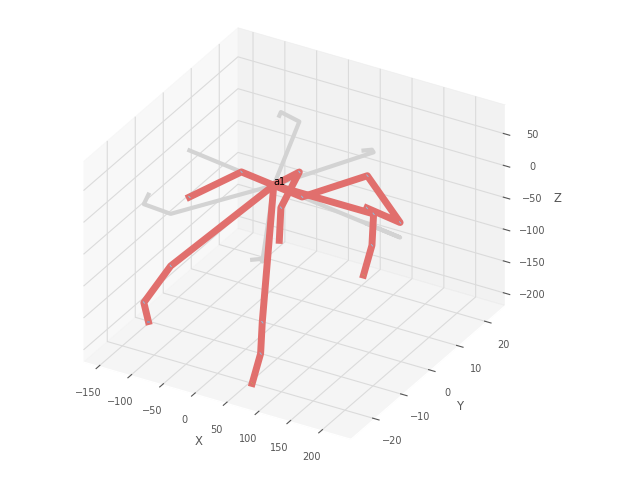

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'a1')

In [10]:
%matplotlib widget
robot.plot(np.zeros(robot.n), backend="pyplot")